In [37]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut
import bayesian as bay

## Data extraction and fit

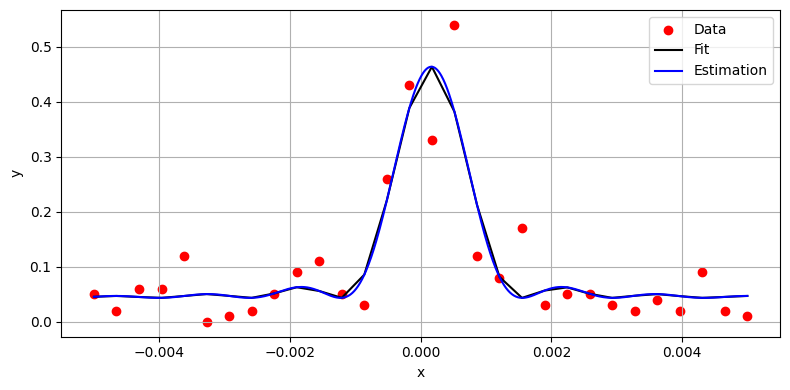

In [43]:
import numpy as np
import json
import matplotlib.pyplot as plt
from lmfit import Model

def sinc(x, a, b, c, d):
    sinc_term = np.sinc(b * (x-d) / np.pi) ** 2  # sinc(x) = sin(pi*x)/(pi*x)
    return c * sinc_term + a

max_frequency_mhz = 0.005
scan_points = 1000

freq = np.linspace(-max_frequency_mhz, max_frequency_mhz, scan_points)



dfile = json.load(open('/home/sdruci/QIC/QIC/project/odf_json/18_10_19_074236.json'))
data = np.array(dfile['data']['mean_excitation']['values'])

x_data = data[:, 1]  
y_data = data[:, 0]  

model = Model(sinc)

params = model.make_params(
    a=0.0455,  
    b=2263.33, 
    c=0.4067,  
    d =0.001
)

result = model.fit(y_data, params, x=x_data)

y_estimated = sinc(freq, **result.best_values)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x_data, y_data, color='red', label='Data')
ax.plot(x_data, sinc(x_data, **result.best_values), color='black', label='Fit')
ax.plot(freq, y_estimated, color='blue', label='Estimation')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Functions for Fit and Find peaks

In [38]:
import numpy as np
import json
import matplotlib.pyplot as plt
from lmfit import Model
import numpy as np
from scipy.signal import find_peaks

def sinc(x, a, b, c, d):
    sinc_term = np.sinc(b * (x-d) / np.pi) ** 2  # sinc(x) = sin(pi*x)/(pi*x)
    return c * sinc_term + a


def odf(freq):

    dfile = json.load(open('/home/sdruci/QIC/QIC/project/odf_json/18_10_19_074236.json'))
    data = np.array(dfile['data']['mean_excitation']['values'])

    x_data = data[:, 1]  # x axis 
    y_data = data[:, 0]  

    model = Model(sinc)

    params = model.make_params(
        a=0.0455,  
        b=2263.33,  
        c=0.4067,   
        d =0.001
    )

    # params['b'].min = 1000
    # params['c'].min = 0     

    result = model.fit(y_data, params, x=x_data)

    # print(result.fit_report())

    y_estimated = sinc(freq, **result.best_values)
    residuals = y_data - result.best_fit
    rmse = np.sqrt(np.mean(residuals**2))
    # print(f"Root mean square error (RMSE): {rmse:.6f}")

    return y_estimated


def find_main_peaks(freq, prob):
    """
    Find the two main peaks in the spectrum.

    - Identifies all local maxima in the excitation curve.
    - Selects the two main peaks.
    - Sorts the two peaks based on frequency (from lowest to highest).

    Parameters:
    freq : array-like
        Array of frequencies.
    prob : array-like
        Array of excitation probabilities.

    Returns:
    tuple of two floats
        The frequencies of the two main peaks sorted in ascending order.
    """
    freq = np.asarray(freq)
    prob = np.asarray(prob)
    
    peaks, _ = find_peaks(prob)
    
    if len(peaks) < 2:
        raise ValueError("Less than 2 peaks found. Check the data")

    peak_indices = peaks[np.argsort(prob[peaks])[-2:]] 

    peak_frequencies = freq[peak_indices]

    peak_frequencies.sort()

    return peak_frequencies[0], peak_frequencies[1]


## Unpumped spectrum with ODF peaks at different B fields

duration_us=1000; rabi_rate_mhz=2 $\pi$ 0.001

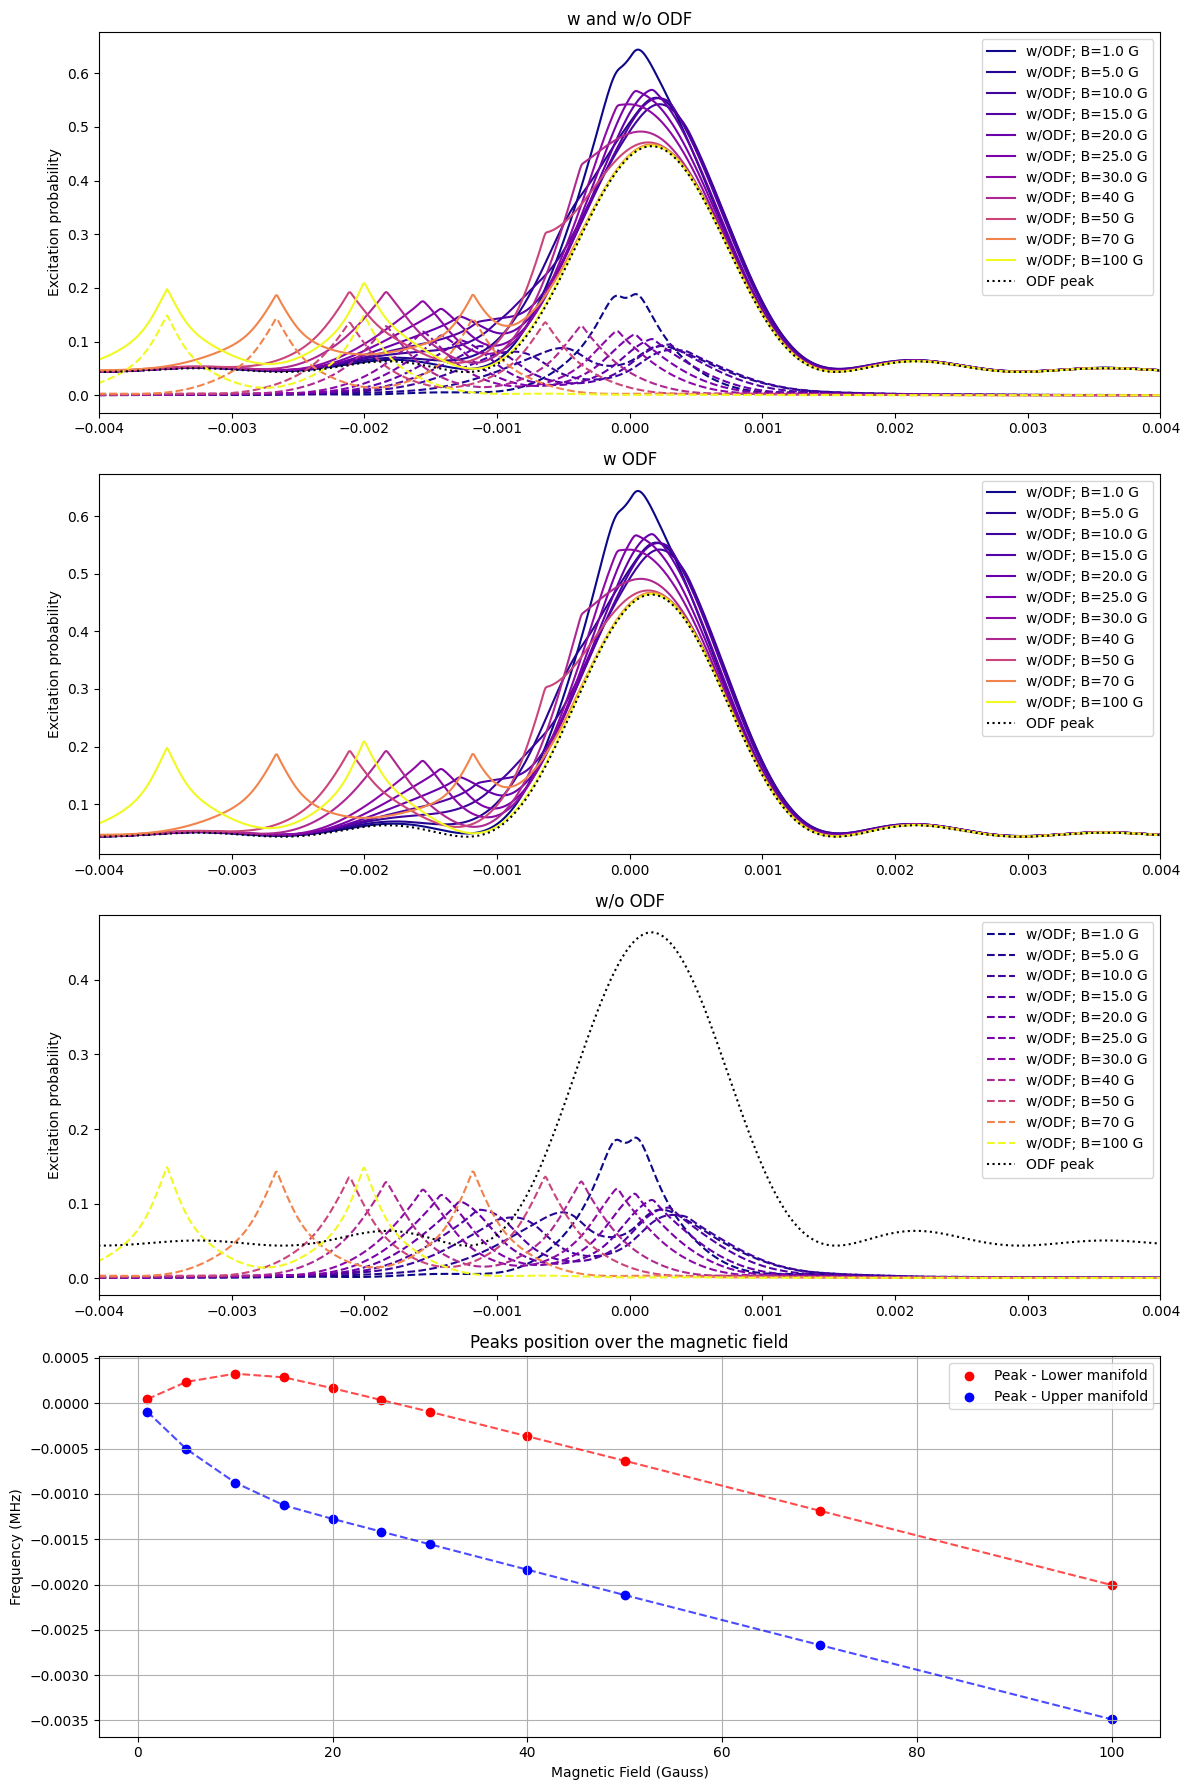

In [60]:
import matplotlib.pyplot as plt
import numpy as np

j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2 * np.pi * 0.001,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

# b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]
b_field_gauss = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40, 50, 70, 100]

pos_peaks = []
neg_peaks = []

cmap = plt.get_cmap("plasma") 
norm = plt.Normalize(vmin=min(b_field_gauss), vmax=max(b_field_gauss))
colors = [cmap(norm(b)) for b in b_field_gauss]


fig, axs = plt.subplots(4, 1, figsize=(12, 18))

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    odf_false_positive = odf(frequencies)

    exc_probs_odf = exc_probs + odf_false_positive
    freq_neg_peak, freq_pos_peak = find_main_peaks(frequencies, exc_probs)
    neg_peaks.append(freq_neg_peak)
    pos_peaks.append(freq_pos_peak)

    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--') 

    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")


for ax in axs[0:3]:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_xlim(-0.004, 0.004)
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()
# axs[2].set_xlim(-0.004, 0.004)

axs[3].scatter(b_field_gauss, pos_peaks, color='r', label="Peak - Lower manifold")
axs[3].plot(b_field_gauss, pos_peaks, color='r', linestyle="--", alpha=0.7)
axs[3].scatter(b_field_gauss, neg_peaks, color='b', label="Peak - Upper manifold")
axs[3].plot(b_field_gauss, neg_peaks, color='b', linestyle="--", alpha=0.7)
axs[3].set_xlabel("Magnetic Field (Gauss)")
axs[3].set_ylabel("Frequency (MHz)")
axs[3].set_title("Peaks position over the magnetic field")
axs[3].legend()
axs[3].grid(True)


plt.tight_layout()
plt.show()


duration_us=5000; rabi_rate_mhz=2 $\pi$ 0.001

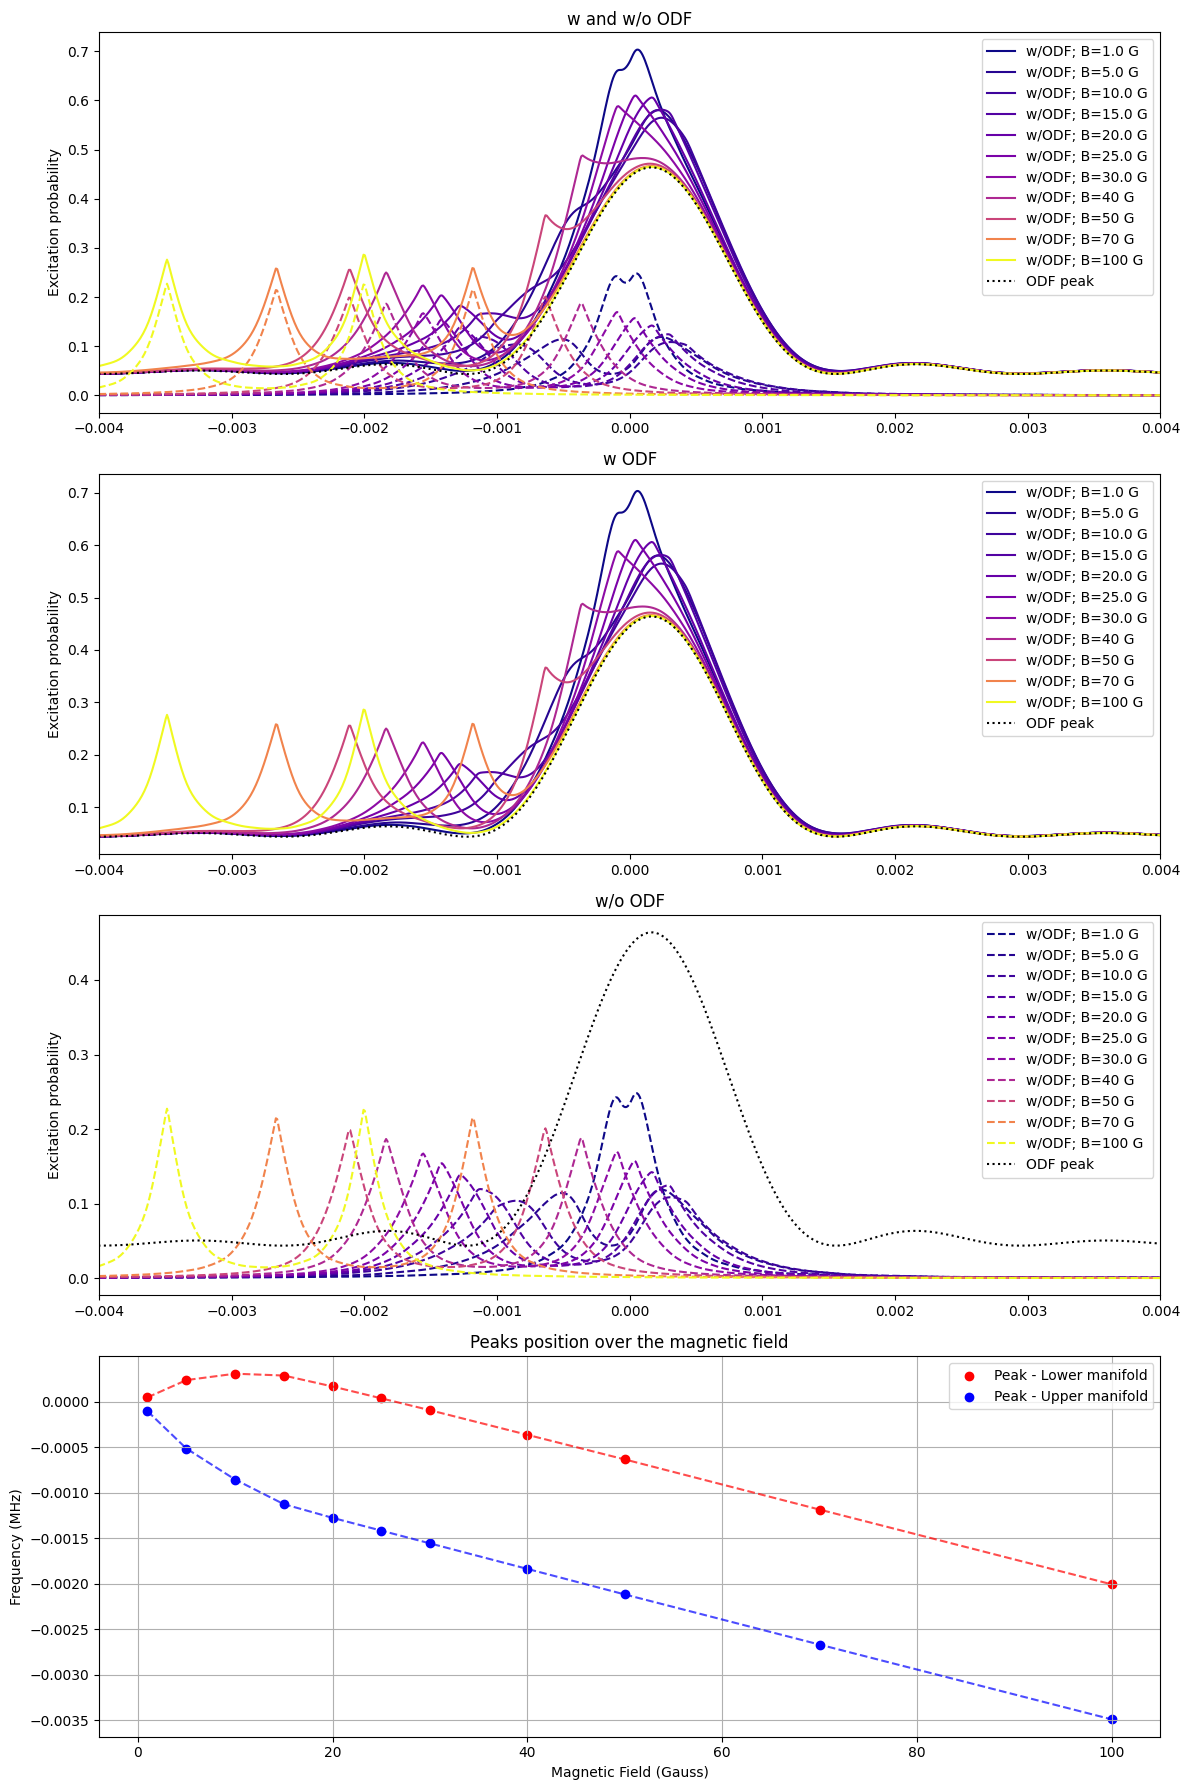

In [61]:
import matplotlib.pyplot as plt
import numpy as np

j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 5000,
    'rabi_rate_mhz': 2 * np.pi * 0.001,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

# b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]
b_field_gauss = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40, 50, 70, 100]

pos_peaks = []
neg_peaks = []

cmap = plt.get_cmap("plasma") 
norm = plt.Normalize(vmin=min(b_field_gauss), vmax=max(b_field_gauss))
colors = [cmap(norm(b)) for b in b_field_gauss]


fig, axs = plt.subplots(4, 1, figsize=(12, 18))

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    odf_false_positive = odf(frequencies)

    exc_probs_odf = exc_probs + odf_false_positive
    freq_neg_peak, freq_pos_peak = find_main_peaks(frequencies, exc_probs)
    neg_peaks.append(freq_neg_peak)
    pos_peaks.append(freq_pos_peak)

    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--') 

    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")


for ax in axs[0:3]:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_xlim(-0.004, 0.004)
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()
# axs[2].set_xlim(-0.004, 0.004)

axs[3].scatter(b_field_gauss, pos_peaks, color='r', label="Peak - Lower manifold")
axs[3].plot(b_field_gauss, pos_peaks, color='r', linestyle="--", alpha=0.7)
axs[3].scatter(b_field_gauss, neg_peaks, color='b', label="Peak - Upper manifold")
axs[3].plot(b_field_gauss, neg_peaks, color='b', linestyle="--", alpha=0.7)
axs[3].set_xlabel("Magnetic Field (Gauss)")
axs[3].set_ylabel("Frequency (MHz)")
axs[3].set_title("Peaks position over the magnetic field")
axs[3].legend()
axs[3].grid(True)


plt.tight_layout()
plt.show()


duration_us=1000; rabi_rate_mhz=2 $\pi$ 0.005

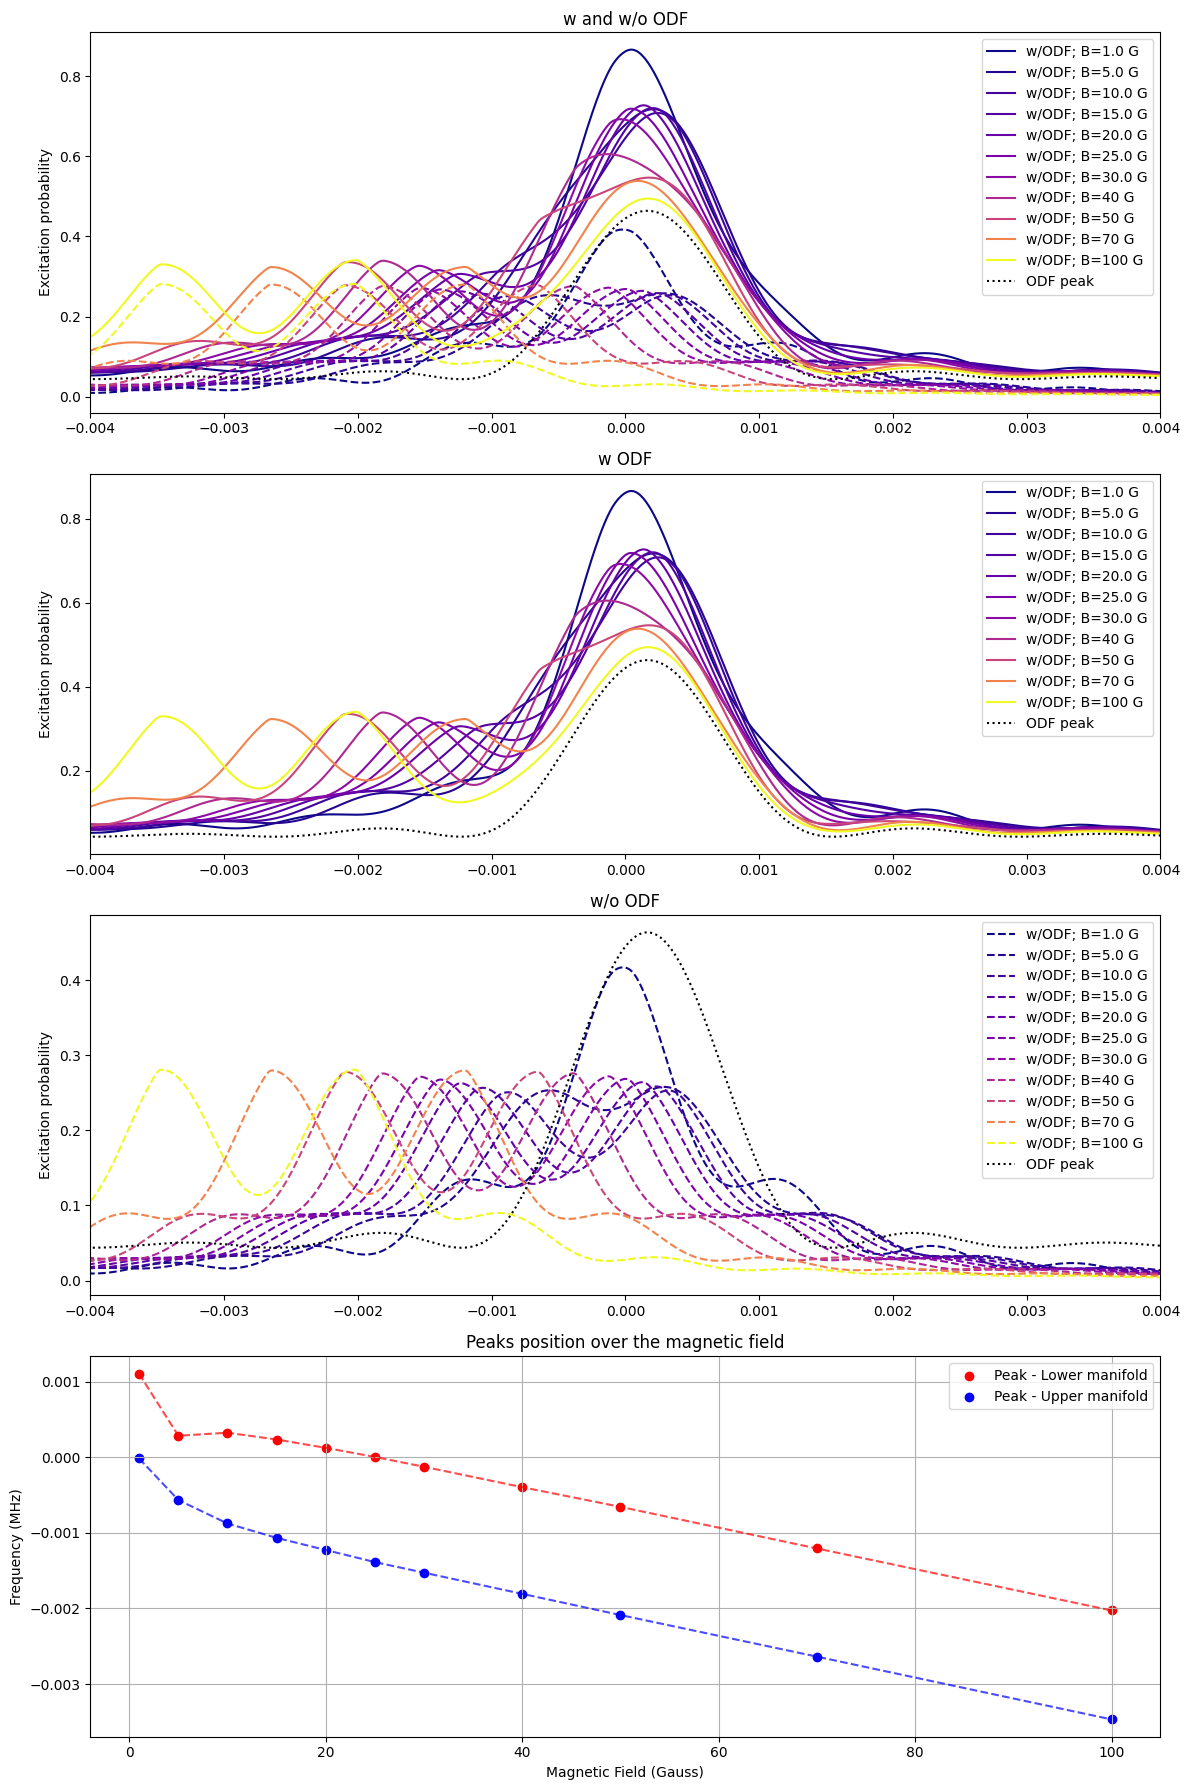

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2 * np.pi * 0.005,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

# b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]
b_field_gauss = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40, 50, 70, 100]

pos_peaks = []
neg_peaks = []

cmap = plt.get_cmap("plasma") 
norm = plt.Normalize(vmin=min(b_field_gauss), vmax=max(b_field_gauss))
colors = [cmap(norm(b)) for b in b_field_gauss]


fig, axs = plt.subplots(4, 1, figsize=(12, 18))

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    odf_false_positive = odf(frequencies)

    exc_probs_odf = exc_probs + odf_false_positive
    freq_neg_peak, freq_pos_peak = find_main_peaks(frequencies, exc_probs)
    neg_peaks.append(freq_neg_peak)
    pos_peaks.append(freq_pos_peak)

    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--') 

    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")


for ax in axs[0:3]:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_xlim(-0.004, 0.004)
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()
# axs[2].set_xlim(-0.004, 0.004)

axs[3].scatter(b_field_gauss, pos_peaks, color='r', label="Peak - Lower manifold")
axs[3].plot(b_field_gauss, pos_peaks, color='r', linestyle="--", alpha=0.7)
axs[3].scatter(b_field_gauss, neg_peaks, color='b', label="Peak - Upper manifold")
axs[3].plot(b_field_gauss, neg_peaks, color='b', linestyle="--", alpha=0.7)
axs[3].set_xlabel("Magnetic Field (Gauss)")
axs[3].set_ylabel("Frequency (MHz)")
axs[3].set_title("Peaks position over the magnetic field")
axs[3].legend()
axs[3].grid(True)


plt.tight_layout()
plt.show()


## Sketch of a PUMPED spectrum

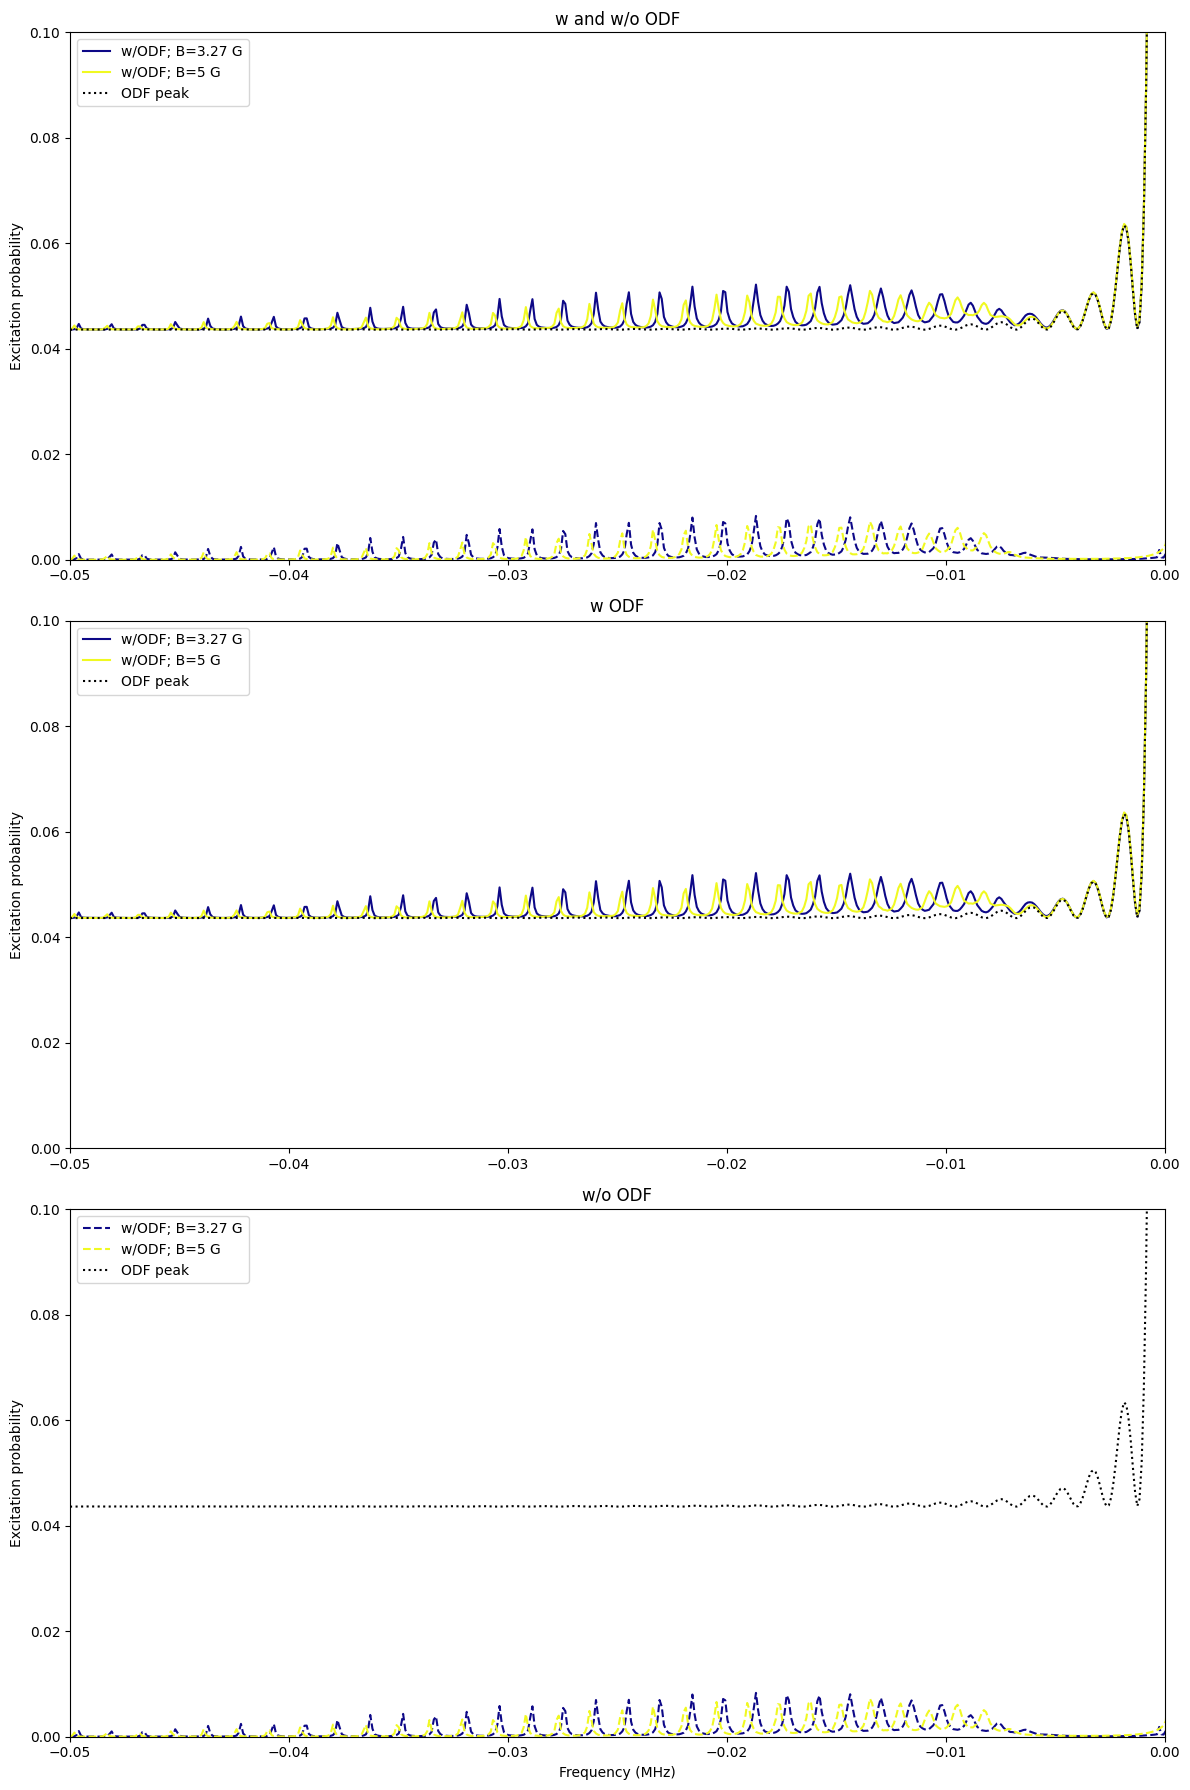

In [41]:
import matplotlib.pyplot as plt
import numpy as np

j_max = 50
temperature = 300


coherence_time_us = 1600
is_minus = True

spectrum_list = {
    'duration_us': 5000,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'max_frequency_mhz': 0.05,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}


pump_list = {
    'pump_frequency_mhz': 0.00015,
    'num_pumps': 1000,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': 2*np.pi*0.005,
    'pump_dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}

b_field_gauss = [3.27, 5]
# b_field_gauss = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40, 50, 70, 100]

pos_peaks = []
neg_peaks = []

cmap = plt.get_cmap("plasma") 
norm = plt.Normalize(vmin=min(b_field_gauss), vmax=max(b_field_gauss))
colors = [cmap(norm(b)) for b in b_field_gauss]


fig, axs = plt.subplots(3, 1, figsize=(12, 18))

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    qls.apply_pumping(molecule=mo1, **pump_list, noise_params = None, seed = None)

    pump_list['pump_frequency_mhz'] = -0.00035

    qls.apply_pumping(molecule=mo1, **pump_list, noise_params = None, seed = None)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    odf_false_positive = odf(frequencies)

    exc_probs_odf = exc_probs + odf_false_positive
    freq_neg_peak, freq_pos_peak = find_main_peaks(frequencies, exc_probs)
    neg_peaks.append(freq_neg_peak)
    pos_peaks.append(freq_pos_peak)

    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--') 

    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")


for ax in axs[0:3]:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_xlim(-0.05, 0)
    ax.set_ylim(0, 0.1)
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()
# axs[2].set_xlim(-0.004, 0.004)

plt.tight_layout()
plt.show()


### Analysis of the zeeman energies at high B (non stretched states)

In [34]:
# EXACT SOLUTION functions

def en_plus_exact(molecule, j, B_gauss, ms_plus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    x_plus = (1 / 2) * np.sqrt((h**2)*cij**2 * ((j + 1 / 2) ** 2 - ms_plus**2) + (h*cij * ms_plus - mu_N * b_Tesla *(gj - gI)) ** 2)

    e = h * cij /4 - gj * mu_N * b_Tesla * ms_plus - x_plus # J 

    e = e * 1e-3 /h     # kHz

    return e 

def en_minus_exact(molecule, j, B_gauss, ms_minus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    x_minus = (1 / 2) * np.sqrt((h**2)*cij**2 * ((j + 1 / 2) ** 2 - ms_minus**2) + (h*cij * ms_minus - mu_N * b_Tesla *(gj - gI)) ** 2)

    e = h * cij /4 - gj * mu_N * b_Tesla * ms_minus + x_minus # J 

    e = e * 1e-3 /h     # kHz

    return e 


# ZEEMAN REGIME functions

def en_plus_zeeman(molecule, j, B_gauss, ms_plus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    Delta_J = h*cij*(j+1/2) /2
    g_z = gj - (gj - gI)/(2*j+1)

    e = h * cij /4 - Delta_J - g_z * mu_N * b_Tesla * ms_plus    # J 

    e = e * 1e-3 /h     # kHz

    return e 

def en_minus_zeeman(molecule, j, B_gauss, ms_minus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    Delta_J = h*cij*(j+1/2) /2
    g_z = gj + (gj - gI)/(2*j+1)

    e = h * cij /4 + Delta_J - g_z * mu_N * b_Tesla * ms_minus    # J 

    e = e * 1e-3 /h     # kHz
    return e 


# PASCHEN-BACK REGIME functions

def en_plus_paschen(molecule, j, B_gauss, ms_plus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    x_plus = (1 / 2) * (h*cij*ms_plus - mu_N * b_Tesla *(gj - gI)) 

    e = h * cij /4 - gj * mu_N * b_Tesla * ms_plus - x_plus # J 

    e = e * 1e-3 /h     # kHz

    return e 

def en_minus_paschen(molecule, j, B_gauss, ms_minus):
    b_Tesla = B_gauss *1e-4
    cij = molecule.cij_khz * 1e3   #Hz
    gj = molecule.gj   # const

    x_minus = (1 / 2) * (h*cij*ms_minus - mu_N * b_Tesla *(gj - gI)) 

    e = h * cij /4 - gj * mu_N * b_Tesla * ms_minus + x_minus # J 

    e = e * 1e-3 /h     # kHz
    return e 

## Exact solutions

In [ ]:
b_field_gauss = 100
j_max = 50

mo1 = CaOH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

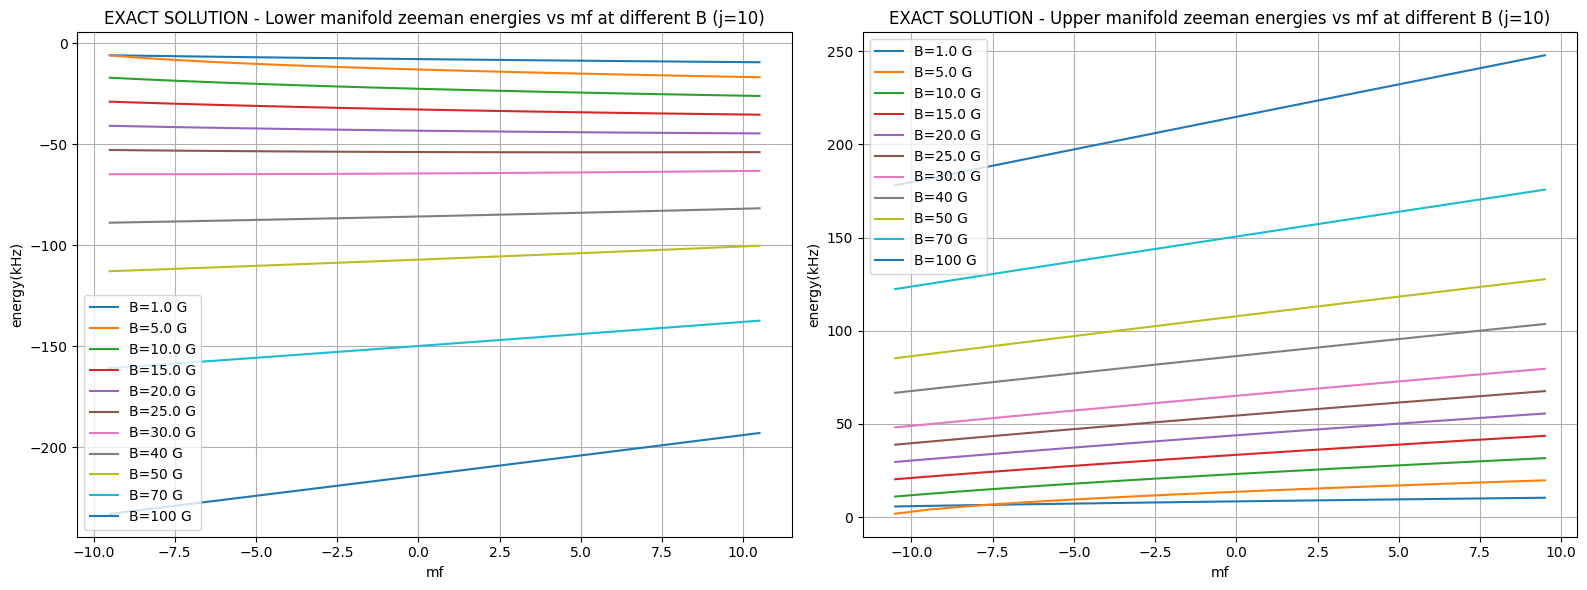

In [26]:
j = 10
ms_minus = mo1.m_csi_minus(j)
ms_plus = mo1.m_csi_plus(j)


fig, axs = plt.subplots(1,2,figsize=(16, 6))

B_gauss = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40, 50, 70, 100]

for B in B_gauss:
    en_lower_manifold = en_plus_exact(mo1,j,B,ms_plus)
    en_upper_manifold = en_minus_exact(mo1,j,B,ms_minus)


    axs[0].plot(ms_plus, en_lower_manifold, linestyle='-', label=f"B={B} G")
    axs[1].plot(ms_minus, en_upper_manifold, linestyle='-', label=f"B={B} G")



axs[0].set_xlabel("mf")
axs[0].set_ylabel("energy(kHz)")
axs[0].set_title(f"EXACT SOLUTION - Lower manifold zeeman energies vs mf at different B (j={j})")
axs[0].legend()
axs[0].grid(True)

axs[1].set_xlabel("mf")
axs[1].set_ylabel("energy(kHz)")
axs[1].set_title(f"EXACT SOLUTION - Upper manifold zeeman energies vs mf at different B (j={j})")
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()
    
    

Testing Zeeman Regime formulas

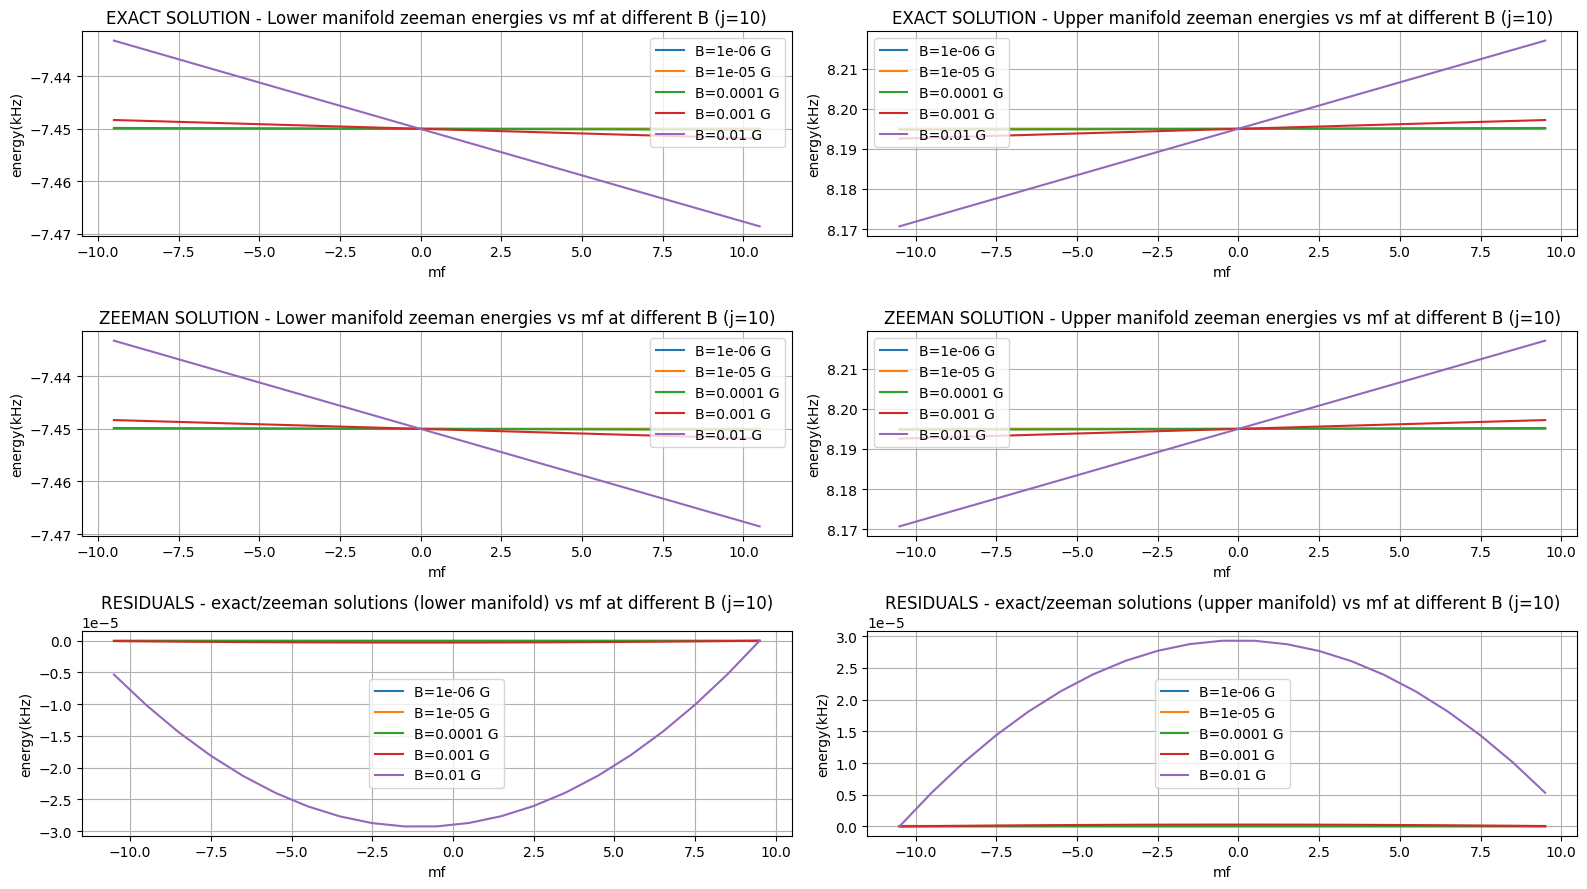

In [35]:
j = 10
ms_minus = mo1.m_csi_minus(j)
ms_plus = mo1.m_csi_plus(j)


fig, axs = plt.subplots(3,2,figsize=(16, 9))

B_gauss = [1e-6,1e-5,1e-4,1e-3,1e-2]

for B in B_gauss:
    # EXACTS
    en_lower_exact = en_plus_exact(mo1,j,B,ms_plus)
    en_upper_exact = en_minus_exact(mo1,j,B,ms_minus)

    # ZEEMAN
    en_lower_zeeman = en_plus_zeeman(mo1,j,B,ms_plus)
    en_upper_zeeman = en_minus_zeeman(mo1,j,B,ms_minus)

    lower_residuals = en_lower_exact - en_lower_zeeman
    upper_residuals = en_upper_exact - en_upper_zeeman


    axs[0,0].plot(ms_plus, en_lower_exact, linestyle='-', label=f"B={B} G")
    axs[0,1].plot(ms_minus, en_upper_exact, linestyle='-', label=f"B={B} G")
    axs[1,0].plot(ms_plus, en_lower_zeeman, linestyle='-', label=f"B={B} G")
    axs[1,1].plot(ms_minus, en_upper_zeeman, linestyle='-', label=f"B={B} G")
    axs[2,0].plot(ms_minus, lower_residuals, linestyle='-', label=f"B={B} G")
    axs[2,1].plot(ms_minus, upper_residuals, linestyle='-', label=f"B={B} G")



axs[0,0].set_xlabel("mf")
axs[0,0].set_ylabel("energy(kHz)")
axs[0,0].set_title(f"EXACT SOLUTION - Lower manifold zeeman energies vs mf at different B (j={j})")
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].set_xlabel("mf")
axs[0,1].set_ylabel("energy(kHz)")
axs[0,1].set_title(f"EXACT SOLUTION - Upper manifold zeeman energies vs mf at different B (j={j})")
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].set_xlabel("mf")
axs[1,0].set_ylabel("energy(kHz)")
axs[1,0].set_title(f"ZEEMAN SOLUTION - Lower manifold zeeman energies vs mf at different B (j={j})")
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].set_xlabel("mf")
axs[1,1].set_ylabel("energy(kHz)")
axs[1,1].set_title(f"ZEEMAN SOLUTION - Upper manifold zeeman energies vs mf at different B (j={j})")
axs[1,1].legend()
axs[1,1].grid(True)

axs[2,0].set_xlabel("mf")
axs[2,0].set_ylabel("energy(kHz)")
axs[2,0].set_title(f"RESIDUALS - exact/zeeman solutions (lower manifold) vs mf at different B (j={j})")
axs[2,0].legend()
axs[2,0].grid(True)

axs[2,1].set_xlabel("mf")
axs[2,1].set_ylabel("energy(kHz)")
axs[2,1].set_title(f"RESIDUALS - exact/zeeman solutions (upper manifold) vs mf at different B (j={j})")
axs[2,1].legend()
axs[2,1].grid(True)


plt.tight_layout()
plt.show()
    
    

Testing Paschen Back formulas

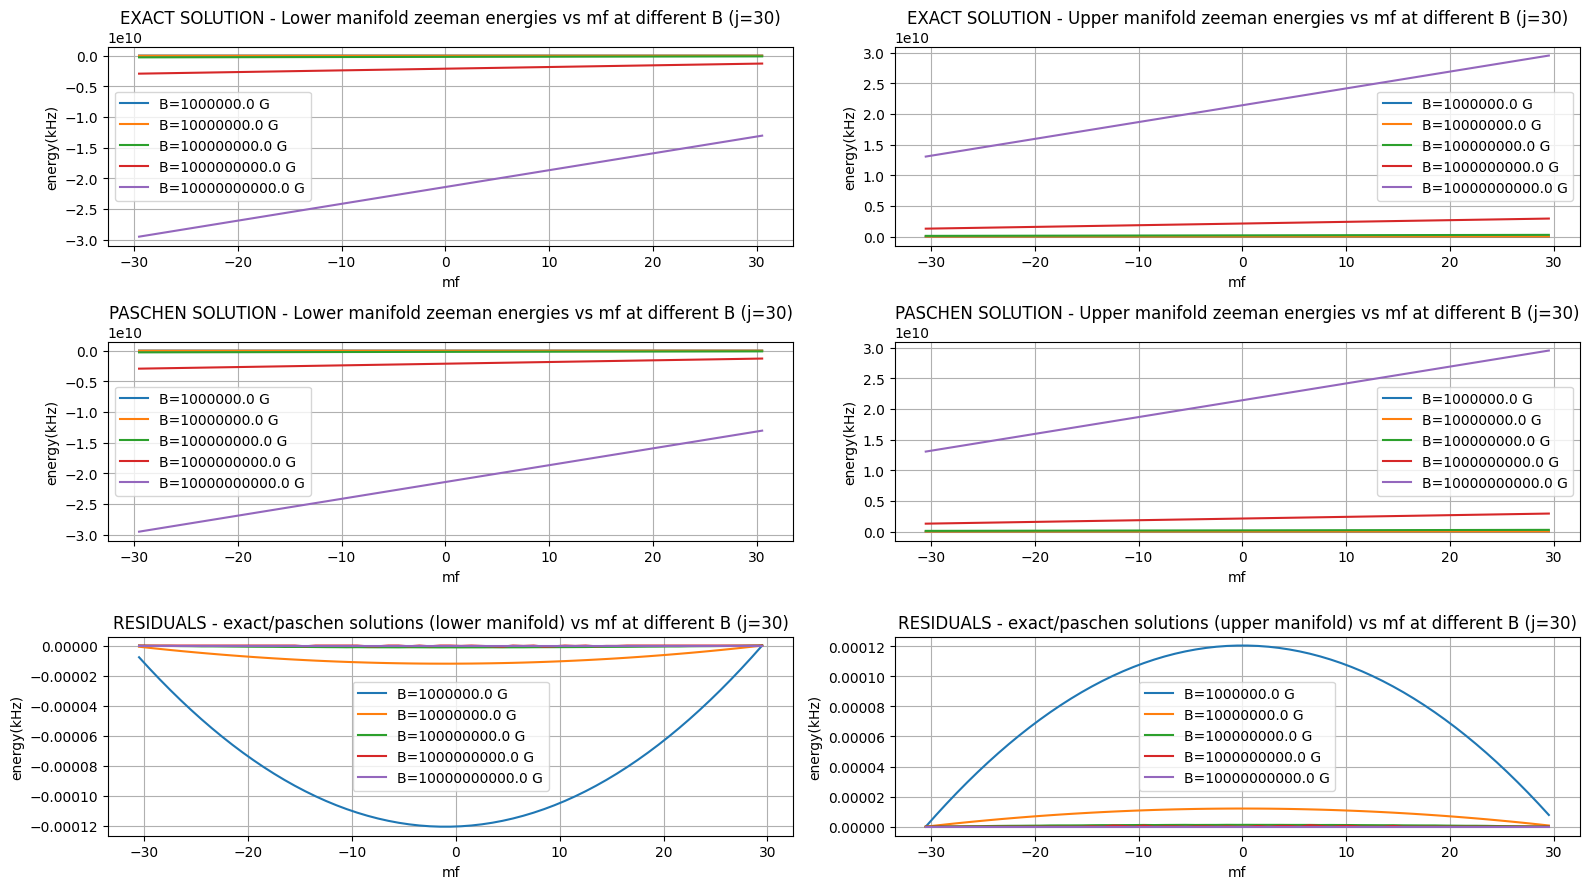

In [33]:
j = 30
ms_minus = mo1.m_csi_minus(j)
ms_plus = mo1.m_csi_plus(j)


fig, axs = plt.subplots(3,2,figsize=(16, 9))

B_gauss = [1e6,1e7,1e8,1e9,1e10]

for B in B_gauss:
    # EXACTS
    en_lower_exact = en_plus_exact(mo1,j,B,ms_plus)
    en_upper_exact = en_minus_exact(mo1,j,B,ms_minus)

    # PASCHEN
    en_lower_paschen = en_plus_paschen(mo1,j,B,ms_plus)
    en_upper_paschen = en_minus_paschen(mo1,j,B,ms_minus)

    lower_residuals = en_lower_exact - en_lower_paschen
    upper_residuals = en_upper_exact - en_upper_paschen


    axs[0,0].plot(ms_plus, en_lower_exact, linestyle='-', label=f"B={B} G")
    axs[0,1].plot(ms_minus, en_upper_exact, linestyle='-', label=f"B={B} G")
    axs[1,0].plot(ms_plus, en_lower_paschen, linestyle='-', label=f"B={B} G")
    axs[1,1].plot(ms_minus, en_upper_paschen, linestyle='-', label=f"B={B} G")
    axs[2,0].plot(ms_minus, lower_residuals, linestyle='-', label=f"B={B} G")
    axs[2,1].plot(ms_minus, upper_residuals, linestyle='-', label=f"B={B} G")



axs[0,0].set_xlabel("mf")
axs[0,0].set_ylabel("energy(kHz)")
axs[0,0].set_title(f"EXACT SOLUTION - Lower manifold zeeman energies vs mf at different B (j={j})")
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].set_xlabel("mf")
axs[0,1].set_ylabel("energy(kHz)")
axs[0,1].set_title(f"EXACT SOLUTION - Upper manifold zeeman energies vs mf at different B (j={j})")
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].set_xlabel("mf")
axs[1,0].set_ylabel("energy(kHz)")
axs[1,0].set_title(f"PASCHEN SOLUTION - Lower manifold zeeman energies vs mf at different B (j={j})")
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].set_xlabel("mf")
axs[1,1].set_ylabel("energy(kHz)")
axs[1,1].set_title(f"PASCHEN SOLUTION - Upper manifold zeeman energies vs mf at different B (j={j})")
axs[1,1].legend()
axs[1,1].grid(True)

axs[2,0].set_xlabel("mf")
axs[2,0].set_ylabel("energy(kHz)")
axs[2,0].set_title(f"RESIDUALS - exact/paschen solutions (lower manifold) vs mf at different B (j={j})")
axs[2,0].legend()
axs[2,0].grid(True)

axs[2,1].set_xlabel("mf")
axs[2,1].set_ylabel("energy(kHz)")
axs[2,1].set_title(f"RESIDUALS - exact/paschen solutions (upper manifold) vs mf at different B (j={j})")
axs[2,1].legend()
axs[2,1].grid(True)


plt.tight_layout()
plt.show()
    
    